$$
\Large \textbf{Problema 01}
$$

<div style="text-align: justify">
Implementación del algoritmo de Metrópolis para una red cuadrada de spines, con el Hamiltoniano dado en la teórica. Se obtendrá una colección representativa de distintos estados del <i>ensemble</i> canónico. Considerar una red cuadrada de $20 \times 20$ espines.<br>
Condiciones de contorno periódicas: Estas condiciones se utilizan para suprimir los efectos de borde. Se busca estudiar la magnetización como si estuviera en el seno de un material magnético (<i>bulk</i>), sin considerar los efectos particulares de las superficies o bordes del sistema. Esta es una forma numérica usual de considerar un sistema infinito.<br>
Tome como configuración inicial del sistema una asignación aleatoria de $1$ o $-1$ para cada spin. Luego de verificar que el programa funcione calcule los valores medios de las magnitudes físicas de interés. Tome para los cálculos $k_B=1$.<br>
</div>
<br>
<div style="text-align: justify">
<u>Consignas:</u>
<ol>
<li>Presentar gráficos de magnetización media y energía media como función de la temperatura.</li>
<li>Calcule el calor específico por partícula y la susceptibilidad a campo nulo.</li>
<li>Discutir brevemente los efectos de tamaño finito, debidos a que las muestras usadas en la simulación tienen un número de espines pequeño en comparación con el límite termodinámico.</li>
<li>A partir de la curva de $M$ vs. $T$, estime la temperatura crítica $T_C$. Explique qué observa con los valores medios de $M$ a medida que se acerca al punto crítico. Tome como referencia que la temperatura crítica del cálculo exacto es $T_C = 2.269$.</li>
</ol> </div>
<br>
<div style="text-align: justify">
<u>Sugerencias:</u><br>
Implementar primero el algoritmo de Monte Carlo y luego de confirmar que está funcionando, agregue las cantidades a medir.<br>
La configuración inicial, al ser aleatoria, pone al sistema en un punto del espacio de fases, que seguramente no será de equilibrio respecto de las condiciones físicas. Realice una primera corrida, de la cual no promediará datos, para <i>termalizar</i> al sistema. Es decir, llegar al equilibrio compatible con las condiciones físicas impuestas. Luego realice otra simulación, desde donde termina la anterior, en la que sí se medirán las magnitudes de interés.<br>
La llegada al equilibrio puede verificarse observando que la energía, por ejemplo, fluctúa respecto de un dado valor en lugar de tener derivas al observar un gráfico de energía vs. paso de Monte Carlo.<br>
Fíjese como no hace falta calcular la energía total de cada configuración, si no sólo la diferencia de energía.<br>
</div>
    
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
plt.rc('figure', figsize=(14, 7))
plt.rc('font', size=14)

### Modelo de Ising
Modelo matemático del ferromagnetismo. Se define una grilla y se asigna a cada elemento un espín $\uparrow (s=1)$ o $\downarrow (s=-1)$.

La energía, para campo magnético externo nulo, es:
$$
E = \frac{J}{2} \sum_i s_i \sum_{j=1}^z s_j
$$
donde $J$ es la constante de interacción, $s_{i,j}$ es el espín y $z$ es el número de primeros vecinos.

La probabilidad de transición entre 2 estados $W1$ y $W2$ es:
$$
P(W_1 \rightarrow W_2) = \left\{ \begin{matrix} 1 & \:\:\:\: si \:\: \Delta E_{W_1 \rightarrow W_2} \le 0 \\ \exp{(-\beta \cdot \Delta E_{W_1 \rightarrow W_2})} & \:\:\:\: si \:\: \Delta E_{W_1 \rightarrow W_2} > 0 \end{matrix} \right.
$$
donde $\beta = \frac{1}{k_B T}$.

#### Algoritmo de Metropolis
La forma básica para resolver el modelo de Ising es:
1. Preparar una configuración inicial de $N$ espines.
2. Elegir un sitio aleatoriamente y calcular la contribución a la energía relacionada con su espín.
2. Variar el espín de dicho sitio y calcular la nueva contribución a la energía.
3. Calcular la variación de energía $dE$.
4. Si $dE<0$ se acepta el cambio con probabilidad $1$. Si $dE>0$ se acepta el cambio con probabilidad $\exp{(-\frac{dE}{T})}$.
5. Se repiten los pasos 2 a 5.

In [2]:
T_C = 2/np.log(1+np.sqrt(2))

## Resolución

In [3]:
N = 20
J = 1

pasos = 1000*(N*N)

In [4]:
def iniciar(N, J):
    '''
    Genera una configuración aleatoria de espines de tamaño N*N y calcula su energía y magnetización.
    '''
    M = 2*np.random.randint(2, size=[N, N])-1
    mu = M.sum()
    E = 0
    for i in range(N):
        for j in range(N):
            E += -J*M[i, j]*(M[i-1, j]+M[i, j-1])
    return M, E, mu

In [5]:
M, E, mu = iniciar(N, J)

print()
print('\033[1m Estado inicial: \033[0m')
print('\033[1m \033[33m    Energía       \033[0m   %-s' % E)
print('\033[1m \033[33m    Magnetización \033[0m   %-s' % mu)
print()


 Estado inicial: 
     Energía          -20
     Magnetización    -6



In [6]:
Mvalues = np.zeros(4)
Temps = np.linspace(6, 0.5, 20)

for T in Temps:
    mu_medio = mu2_medio = E_medio = E2_medio = 0
    vi = np.random.randint(0, N, pasos)
    vj = np.random.randint(0, N, pasos)
    for i, j in zip(vi, vj):
        dE = 2*J*M[i, j]*(M[i-1, j]+M[i-(N-1), j]+M[i, j-1]+M[i, j-(N-1)])
        if dE < 0:
            M[i, j] *= -1
            mu += 2*M[i, j]
            E += dE
        elif np.random.rand(1) < np.exp(-dE/T):
            M[i, j] *= -1
            mu += 2*M[i, j]
            E += dE
        mu_medio += (mu/N**2)/pasos
        mu2_medio += ((mu/N**2)**2)/pasos
        E_medio += (E/N**2)/pasos
        E2_medio += ((E/N**2)**2)/pasos
    values = np.array([mu_medio, mu2_medio, E_medio, E2_medio])
    Mvalues = np.vstack([Mvalues, values])

Mvalues = np.delete(Mvalues, 0, axis=0)

In [7]:
Magnetización = abs(Mvalues[:, 0])
Energía = Mvalues[:, 2]
Susceptibilidad = (Mvalues[:, 1]-(Mvalues[:, 0])**2)/Temps
Calor_específico = (Mvalues[:, 3]-(Mvalues[:, 2])**2)/(Temps**2)

### Gráficos

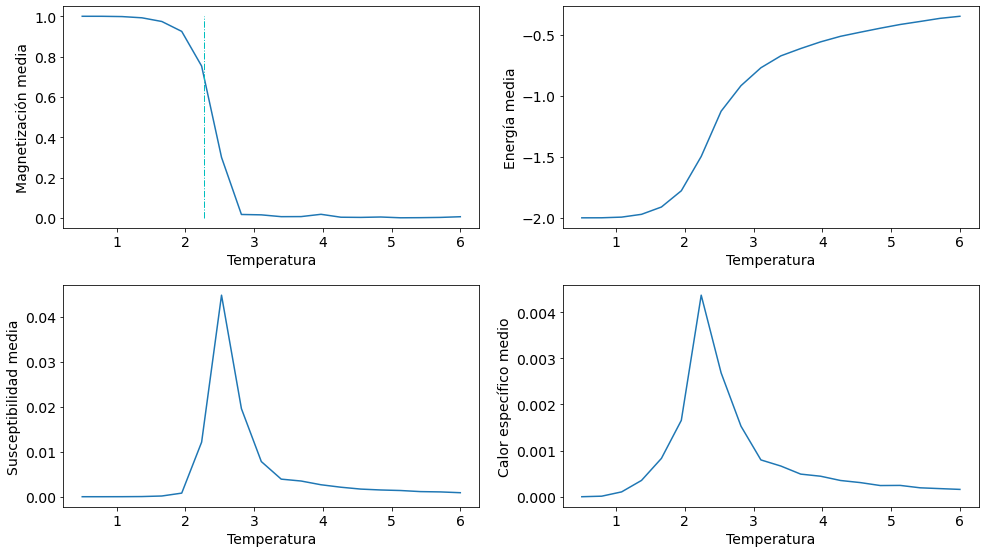

In [8]:
plt.rc('figure', figsize=(14, 8))
fig = plt.figure()
fig.clf()
ax = fig.subplots(2, 2)

ax[0, 0].plot(Temps, Magnetización)
ax[0, 0].plot([T_C, T_C], [0, 1], 'c-.', lw=1)
ax[0, 0].set_xlabel('Temperatura')
ax[0, 0].set_ylabel('Magnetización media')

ax[0, 1].plot(Temps, Energía)
ax[0, 1].set_xlabel('Temperatura')
ax[0, 1].set_ylabel('Energía media')

ax[1, 0].plot(Temps, Susceptibilidad)
ax[1, 0].set_xlabel('Temperatura')
ax[1, 0].set_ylabel('Susceptibilidad media')

ax[1, 1].plot(Temps, Calor_específico)
ax[1, 1].set_xlabel('Temperatura')
ax[1, 1].set_ylabel('Calor específico medio')

fig.tight_layout(pad=1.3)

Nota: La línea punteada indica la temperatura de Curie del cálculo exacto, $T_C=2.269$.

# Evolución de las configuraciones


In [9]:
def configPlot(f, config, k, N, n):
    '''Grafica una configuración'''
    sp = f.add_subplot(3, 3, n)
    plt.imshow(config, cmap=plt.cm.summer)
    plt.title('Tiempo = %d'%k)
plt.show()

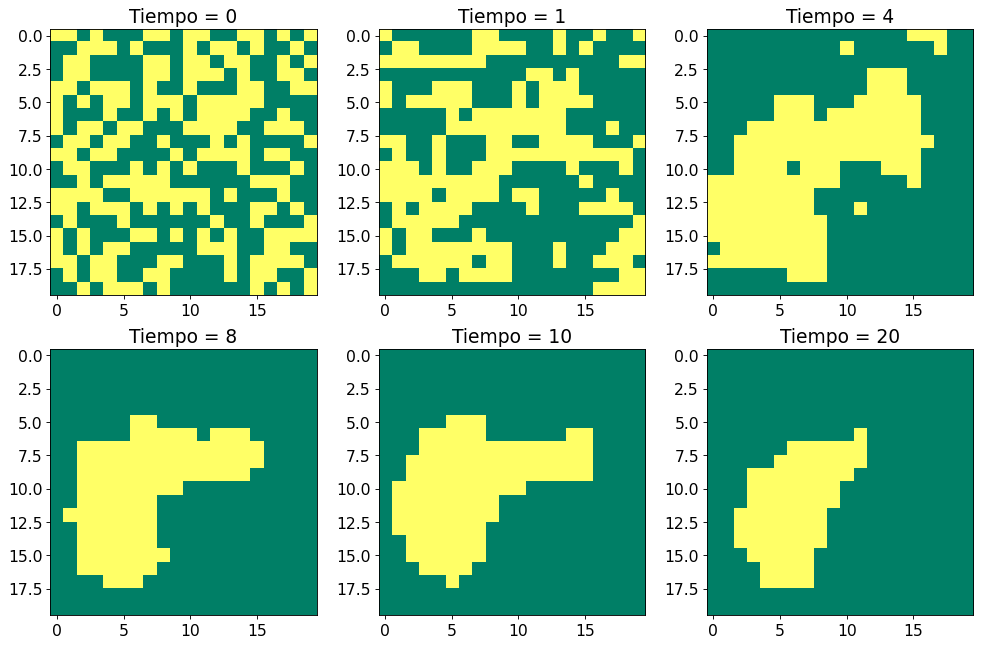

In [10]:
temp = 1
config = 2*np.random.randint(2, size=(N, N))-1
f = plt.figure(figsize=(15, 15), dpi=80)
configPlot(f, config, 0, N, 1)
for k in range(1, 21):
    for i in range(N):
        for j in range(N):
            a = np.random.randint(0, N)
            b = np.random.randint(0, N)
            s = config[a, b]
            dE = 2*J*s*(config[a-1, b] + config[a-(N-1), b] + config[a, b-1] + config[a, b-(N-1)])
            if dE < 0:
                s *= -1
            elif np.random.rand(1) < np.exp(-dE/temp):
                s *= -1
            config[a, b] = s
    if k == 1:
        configPlot(f, config, k, N, 2)
    if k == 4:
        configPlot(f, config, k, N, 3)
    if k == 8:
        configPlot(f, config, k, N, 4)
    if k == 10:
        configPlot(f, config, k, N, 5)
    if k == 20:
        configPlot(f, config, k, N, 6)

Para $T<T_C$, los espines se van alineando (ferromagnetismo).

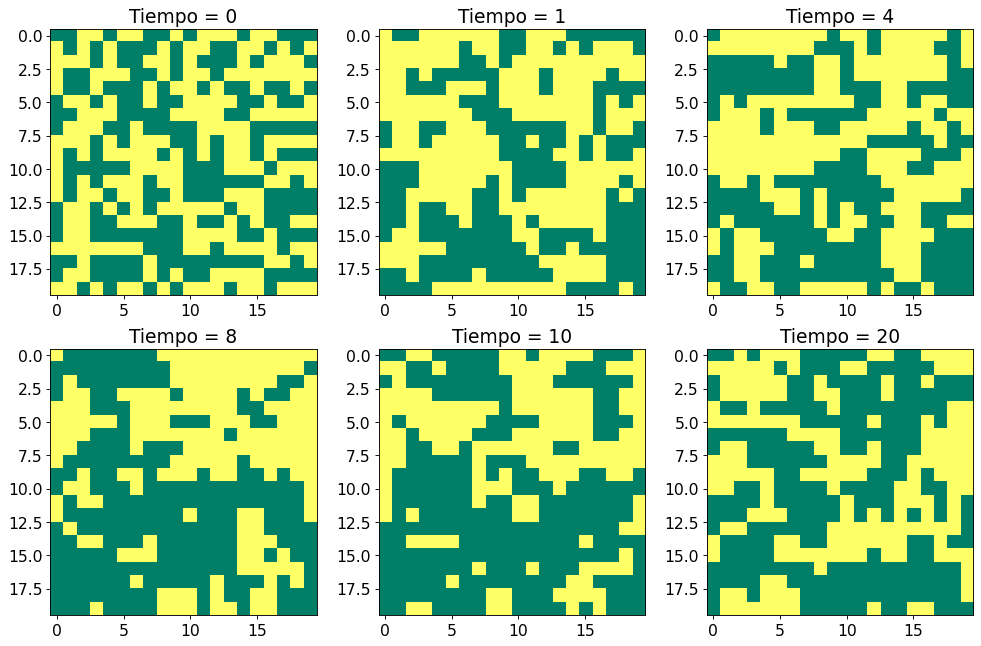

In [11]:
temp = 3
config = 2*np.random.randint(2, size=(N, N))-1
f = plt.figure(figsize=(15, 15), dpi=80)
configPlot(f, config, 0, N, 1)
for k in range(1, 21):
    for i in range(N):
        for j in range(N):
            a = np.random.randint(0, N)
            b = np.random.randint(0, N)
            s = config[a, b]
            dE = 2*J*s*(config[a-1, b] + config[a-(N-1), b] + config[a, b-1] + config[a, b-(N-1)])
            if dE < 0:
                s *= -1
            elif np.random.rand(1) < np.exp(-dE/temp):
                s *= -1
            config[a, b] = s
    if k == 1:
        configPlot(f, config, k, N, 2)
    if k == 4:
        configPlot(f, config, k, N, 3)
    if k == 8:
        configPlot(f, config, k, N, 4)
    if k == 10:
        configPlot(f, config, k, N, 5)
    if k == 20:
        configPlot(f, config, k, N, 6)

Para $T>T_C$, los espines no se ordenan (paramagnetismo).